In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import pandas as pd

# Defining the conv-net class:
## You can set the following parameters of the network:
->Stride

->Kernel size

->optional hidden Dense layer(along with its size)


The structure of the network can be inferred from the code:

In [2]:
#Defining the structure of the convolutional net
class ConvNet(nn.Module):
    def __init__(self,channels=4,kernel_size=5,stride_len=1,hidden_full_layer=False,size_hidden_layer=50):
        super().__init__()
        #Note:Output_size=num_out_channels*([L_in - (Kernel_size -1) -1]/stride   + 1)
        conv_out_size=int(channels*((150 - (kernel_size - 1) -1)/stride_len + 1))
        self.conv_layer=nn.Conv1d(in_channels=1,out_channels=channels,kernel_size=kernel_size,stride=stride_len,bias=True)
        self.fully_connected_ll1=nn.Linear(conv_out_size,size_hidden_layer)
        self.fully_connected_ll2=nn.Linear(size_hidden_layer,4)
        self.fully_connected_ll3=nn.Linear(conv_out_size,4)
        self.hidden_layer_status=hidden_full_layer
        self.activation=nn.modules.activation.LeakyReLU()
    def forward(self,X):
        out1_z=self.conv_layer(X)
        out1_a=self.activation(out1_z)
        out1_reduced_dim=out1_a.reshape(-1,out1_a.shape[1]*out1_a.shape[2]) #Convert the 3-D convolved output into a 2-D Array
                                                                       #that can be processed by Linear layer.
        if self.hidden_layer_status:
            out2_z=self.fully_connected_ll1(out1_reduced_dim)
            out2_a=self.activation(out2_z)
            out3_z=self.fully_connected_ll2(out2_a)
            out3_a=self.activation(out3_z)
            return out3_a
        else:
            out2_z=self.fully_connected_ll3(out1_reduced_dim)
            out2_a=self.activation(out2_z)
            return out2_a   

# Code that was given in the starter pack to generate baseline solution and to load the data for testing and training:

In [3]:
#Defining the baseline regressor:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]  #len=4
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)

In [4]:
#Loading in the data set:
class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))

In [5]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        #arr1=arr[:50]/1000
        #arr2=arr[50:100]/1000
        #arr3=arr[100:150]/1000
        
        data.append(arr/1000)
        Data=np.array(data)
    return Data.reshape(Data.shape[0],1,Data.shape[1])  
    #Data.reshape(Data.shape[1],Data.shape[0],Data.shape[2])


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
#X_test = load_data("test_data")
#print(X_train)
#print(y_train)
print(f"Train data shape: {X_train.shape}")
#print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 1, 150)


In [6]:
#Generating the baseline predictions:
#First we randomly shuffle the data:
Data=np.array(list(zip(X_train,y_train)),dtype=object)
np.random.shuffle(Data)
X_train_new=np.array([x for x in Data[:1500,0]])
y_train_new=np.array([y for y in Data[:1500,1]])
y_train_new_for_NN=np.copy(y_train_new)
X_test_new=np.array([x for x in Data[1500:,0]])
y_test_new=np.array([y for y in Data[1500:,1]])
baseline_reg=BaselineRegressor()
# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test_new)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test_new - baseline_predictions) ** 2, axis=0)

max_arr = y_train_new.max(axis=0)
y_train_new_for_NN = y_train_new_for_NN/max_arr

# Baseline solution's MSE values:

In [7]:
baselines

array([7.93121894e+02, 4.05984296e+03, 1.34661378e+03, 7.30807845e-02])

# The following structure of the network was used for generating the submission file:

Kernel=5x5 ; stride = 5 hidden_layer = True (100 neurons):

In [14]:
#Training the network:
hidden_neurons = [50,100,200,500,1000,2000,3000,4000,5000]
networks = [ConvNet(channels=50,kernel_size=5,stride_len=5,hidden_full_layer=True,size_hidden_layer=i) for i in hidden_neurons]
scores_dict = dict([('P',[]),('K',[]),('Mg',[]),('pH',[]),('fin_score',[])])
for network in networks:
    test=network
    loss=nn.MSELoss()
    num_epochs=100
    mini_batch_size=50
    dataset=TensorDataset(torch.from_numpy(X_train_new.astype(np.float32)),torch.from_numpy(y_train_new_for_NN.astype(np.float32)))
    x_train_graphing=torch.from_numpy(X_train_new.astype(np.float32))
    y_train_graphing=torch.from_numpy(y_train_new_for_NN.astype(np.float32))
    x_test_graphing=torch.from_numpy(X_test_new.astype(np.float32))
    y_test_graphing=y_test_new.copy()/max_arr
    y_test_gr_tensor = torch.from_numpy(y_test_graphing.astype(np.float32))
    Loss=[]
    Loss2=[]
    for epoch in range(num_epochs):
        mini_batches=DataLoader(dataset=dataset,batch_size=mini_batch_size,shuffle=True)
        optimizer=torch.optim.SGD(params=test.parameters(),lr=(0.01)*(1.0001-epoch/num_epochs),momentum=0.1,weight_decay=0.001)
        for mini_batch_in,mini_batch_out in mini_batches:
            outs=test(mini_batch_in)
            l=loss(outs,mini_batch_out)
            l.backward()
            optimizer.step()
        optimizer.zero_grad()
    X_test_tensor=torch.from_numpy(X_test_new.astype(np.float32))
    with torch.no_grad():
        predictions_tensor=test(X_test_tensor)
    predictions=predictions_tensor.numpy()

    predictions = predictions*max_arr
    
    mse=np.mean((predictions-y_test_new)**2,axis=0)

    scores=mse/baselines

    final_score = np.mean(scores)
    
    scores_dict['fin_score'].append(final_score)
    for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
        scores_dict[class_name].append(score)



In [15]:
scores_dict

{'P': [1.0063310666065401,
  1.0071970846051783,
  1.0042254036492788,
  0.9997043332288731,
  1.0003450298293421,
  0.9972535650564539,
  0.9991704629808722,
  0.9971509016545935,
  0.9979278443118315],
 'K': [1.0078134284480003,
  1.004831865543634,
  1.0028839854874854,
  1.0106361906913393,
  1.0024081929090403,
  1.0014407560822198,
  1.0027113968869878,
  1.0035901218281906,
  1.0026540380500477],
 'Mg': [0.9613241541207558,
  0.9582547951978984,
  0.9589451780038271,
  0.9605682635131958,
  0.9582604475552798,
  0.9580778759944915,
  0.9579840987068763,
  0.9664131787501445,
  0.9572228868592473],
 'pH': [0.970538906671339,
  0.9673930757253872,
  0.9750403498421929,
  0.9699304183748091,
  0.9639616758018006,
  0.9778267112465279,
  0.978458499005079,
  0.9509625255084289,
  0.9642325696638451],
 'fin_score': [0.9865018889616588,
  0.9844192052680244,
  0.9852737292456961,
  0.9852098014520543,
  0.9812438365238658,
  0.9836497270949233,
  0.9845811143949538,
  0.97952918193533

([<matplotlib.axis.XTick at 0x7fb858549450>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

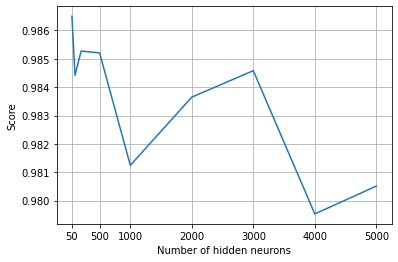

In [23]:
plt.plot(hidden_neurons,scores_dict['fin_score'])
plt.ylabel('Score')
plt.xlabel('Number of hidden neurons')
plt.grid()
plt.xticks([50,500,1000,2000,3000,4000,5000])

In [18]:
predictions

array([[ 68.69225912, 229.80492562, 163.99042606,   6.8523738 ],
       [ 67.9555025 , 225.98361596, 161.61739826,   6.74582616],
       [ 68.01527813, 226.73079744, 161.66713238,   6.76145943],
       [ 71.96887247, 231.01503029, 154.60591316,   6.80608953],
       [ 68.5918808 , 224.34210405, 164.72793818,   6.75184636],
       [ 68.7109381 , 229.47173566, 164.04657364,   6.84627968],
       [ 74.08346161, 231.79344833, 149.85325336,   6.78717721],
       [ 71.96535654, 231.63855076, 154.49825525,   6.80570133],
       [ 70.65803632, 230.80375046, 156.33826256,   6.77786865],
       [ 69.21353675, 224.70952943, 167.25555658,   6.79050786],
       [ 68.61943677, 223.94422442, 164.87708092,   6.74593588],
       [ 75.89024715, 227.77518257, 146.92366123,   6.78799778],
       [ 72.09539749, 231.57563061, 152.79169083,   6.7628049 ],
       [ 68.26497689, 227.9679291 , 162.66440153,   6.79817805],
       [ 69.197255  , 224.54768419, 167.17621088,   6.78606513],
       [ 68.75141971, 224

# Generating final predictions:

In [75]:
X_test = load_data("test_data")
X_test_fin_tensor=torch.from_numpy(X_test.astype(np.float32))

In [77]:
with torch.no_grad():
    predictions_tensor_fin=test(X_test_fin_tensor)
predictions_fin=predictions_tensor_fin.numpy()
predictions_fin = predictions_fin*max_arr

In [78]:
submission = pd.DataFrame(data = predictions_fin, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission_conv.csv", index_label="sample_index")

In [80]:
df = pd.read_csv("submission_conv.csv")

In [84]:
df

,sample_index,P,K,Mg,pH
0,0,69.903686,228.016246,163.168490,6.768649
1,1,69.182935,229.931269,165.810752,6.797529
2,2,70.764173,227.754414,165.791833,6.798767
3,3,69.956550,229.360647,167.099011,6.799633
4,4,69.654379,221.097395,165.873146,6.842845
...,...,...,...,...,...
1149,1149,68.240114,227.938313,163.987350,6.794326
1150,1150,67.869367,229.322296,163.089669,6.775237
1151,1151,69.571299,222.467352,166.561067,6.838596
1152,1152,68.042824,228.583850,163.279438,6.783016
